In [350]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
import pathlib
import common

FONT_SIZE = 15
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

In [352]:
fig_dir = '/data/zhenyus/webcachesim/notebook/figures/'
data_prefix = '/data/zhenyus/webcachesim/ats_log'
sleep_time = 15.
max_log2_client = 8
n_client = 256
size = '128G'
# algs = ['fifo', 'lru', 'static']
# algs = algs = ['fifo', 'lru', 'gbdt']
algs = ['fifo', 'gbdt']
unit = 'm' 
means = [0, 300]
gbdt_version = '_fix_mem'

In [353]:
marker_map = {
#     'Belady': '1',
#     'S4LRU': 'd',
#     'LFUDA': 'o',
#     'Adaptive-TinyLFU': 'v',
#     'BeladySample': '#000080',
    'gbdt': '*',
    'fifo': '2',
#     'LR': 'r',
#     'LRUK': '>',
    
#     'GDSF': '8',
#     'LRU': 's',

    
#     'Hyperbolic': 'chartreuse',
#     'LeCaR': 'p',
#     'AdaptSize': 'P',
#     'LHD': '+',
#     'GDWheel': 'x',
    
}

In [354]:
color_map = {
    'gbdt': 'b',
    'fifo': 'r',
#     'Belady': 'k',
#     'BeladySample': '#000080',
#     'GDBT': 'b',
#     'LR': 'r',
#     'LRUK': 'g',
#     'FIFO': 'r',
#     'LFUDA': '#808080',
#     'GDSF': 'm',
#     'LRU': 'm',
#     'S4LRU': 'r',
#     'LHD': 'r',
#     'Hyperbolic': 'chartreuse',
#     'LeCaR': '#ed740b',
#     'AdaptSize': '#669999',

#     'GDWheel': '#000080',
#     'Adaptive-TinyLFU': 'burlywood',
}

In [355]:
linestyle_map = {
    'max': ':',
    'normal': '-',
}

In [356]:
workload_label_map = {
    'max': 'Max',
    'normal': 'Normal',
}

In [357]:
alg_label_map = {
    'gbdt': 'WLC',
    'fifo': 'ATS',
}

In [358]:
trace_map = {
    'traceHK.tr': 'Akamai HK',
    'traceUS.tr': 'Akamai US',
    'wc200m.tr': 'Wikipedia',
    'wc400m.tr': 'Wikipedia',
    'memc_200m.tr': 'Memcachier',
    'msr_big_200m.tr': 'MSR Storage',
    'anonymous_200m.tr': 'Anonymous Application',
    'caida_cache_200m.tr': 'Caida',
}

In [359]:
def label_map(alg):
    if alg == 'Adaptive-TinyLFU':
        return 'TinyLFU'
    return alg

In [360]:
res = []
for mean in means:
    for alg in algs:
        if alg == 'gbdt' and mean == 0:
            df = pd.read_csv(f'{data_prefix}/latency_{unit}_{alg}_{size}_{mean}{gbdt_version}.log', names=['t', 'log10_ns_latency', 'n'], delimiter=' ')        
        else:
            df = pd.read_csv(f'{data_prefix}/latency_{unit}_{alg}_{size}_{mean}.log', names=['t', 'log10_ns_latency', 'n'], delimiter=' ')
        df = df[df.t == 'fb']
        df['latency_ms'] = (10**df['log10_ns_latency'])/1e6
        df['alg'] = alg
        if mean == 0:
            df['workload'] = 'max'
        else:
            df['workload'] = 'normal'
        res.append(df)
df = pd.concat(res)

In [361]:
FONT_SIZE = 30
plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title
matplotlib.rc('lines', linewidth=3)

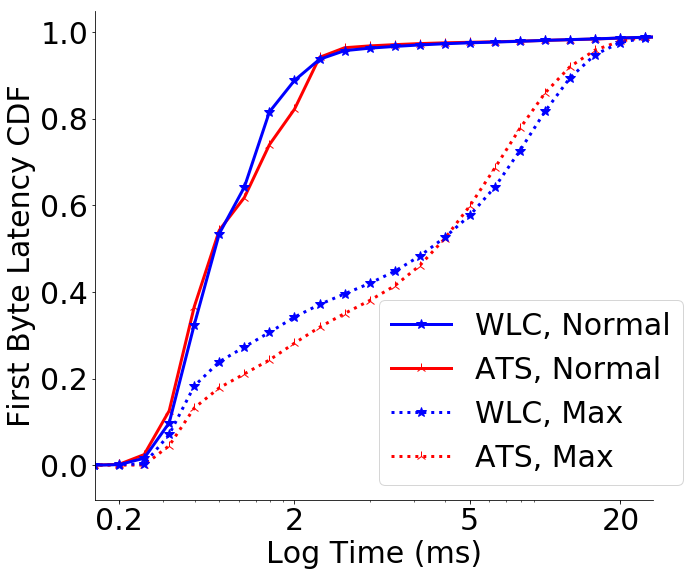

In [362]:
fig, ax = plt.subplots(figsize=(10, 9))
for l, grp in df.groupby(['workload', 'alg']):
    workload, alg = l[0], l[1]
    grp = grp.sort_values('latency_ms')
    y = np.cumsum(grp.n)
    ax.semilogx(
        grp['latency_ms'],
        y/y.max(), 
        marker=marker_map[alg], 
        label=f'{alg_label_map[alg]}, {workload_label_map[workload]}',
        color=color_map[alg],
        markersize=11,
        linestyle=linestyle_map[workload],
    )
plt.ylim([-0.08, 1.05])
plt.xlim([0.16, 27])
ax.set_xticks((0.2, 1, 5, 20))
ax.set_xticklabels(('0.2', '2', '5', '20')) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel(f'Log Time (ms)')
plt.ylabel('First Byte Latency CDF')
handles, labels = ax.get_legend_handles_labels()
permutations = [3, 2, 1, 0]
manual_handles = [handles[i] for i in permutations]
manual_labels = [labels[i] for i in permutations]
plt.legend(manual_handles, 
           manual_labels,
           loc='lower right',
           bbox_to_anchor=(1.08, 0)
          )
plt.savefig(f"{fig_dir}/evaluation_latency.pdf",
        bbox_inches = 'tight', 
        pad_inches = 0)
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5,
#            labelspacing=0.1,
#           handletextpad=0.3)
# plt.title(f'Latency - Throughput')
plt.show()

In [320]:
labels

['ATS, Max', 'WLC, Max', 'ATS, Normal', 'WLC, Normal']

In [ ]:
grp

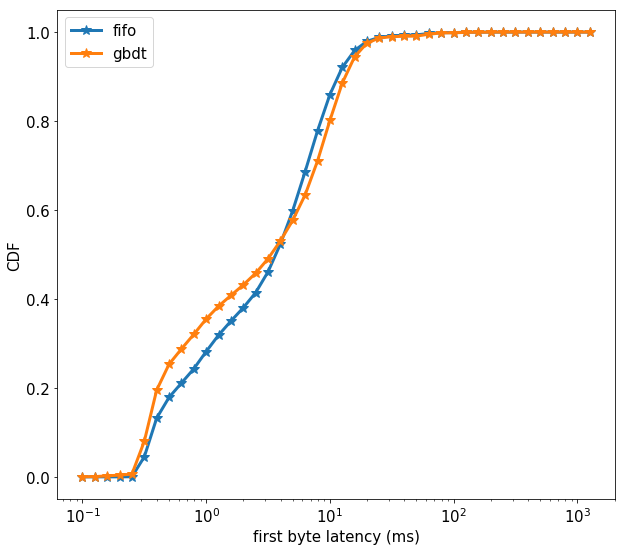

In [84]:
fig, ax = plt.subplots(figsize=(10, 9))
for l, grp in df.groupby('alg'):
    grp = grp.sort_values('latency_ms')
    y = np.cumsum(grp.n)
    ax.semilogx(
        grp['latency_ms'],
        y/y.max(), 
        marker='*', 
        label=l,
        markersize=10,
    )
# plt.ylim(bottom=0)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.xlabel(f'first byte latency (ms)')
plt.ylabel('CDF')
plt.legend()
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5,
#            labelspacing=0.1,
#           handletextpad=0.3)
# plt.title(f'Latency - Throughput')
plt.show()

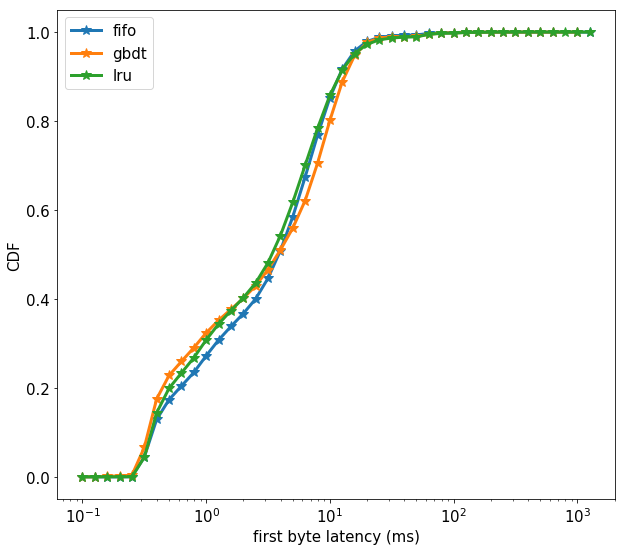

In [64]:
fig, ax = plt.subplots(figsize=(10, 9))
for l, grp in df.groupby('alg'):
    grp = grp.sort_values('latency_ms')
    y = np.cumsum(grp.n)
    ax.semilogx(
        grp['latency_ms'],
        y/y.max(), 
        marker='*', 
        label=l,
        markersize=10,
    )
# plt.ylim(bottom=0)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.xlabel(f'first byte latency (ms)')
plt.ylabel('CDF')
plt.legend()
# plt.legend(ncol=2, 
#            fontsize='small',
#            columnspacing=0.5,
#            labelspacing=0.1,
#           handletextpad=0.3)
# plt.title(f'Latency - Throughput')
plt.show()